## Support vector machines

- Pros: Low generalization error, computationally inexpensive,
    easy to interpret results
- Cons: Sensitive to tuning parameters and kernel choice;
    natively only handles binary classification
- Works with: Numeric values, nominal values

In [1]:
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Implement SVM (without kernel)

In [2]:
# Helper functions for the SMO algorithm
def selectJrand(i, m):
    j = i
    while j == i:
        j = np.random.randint(0, m)
    return j


def clipAlpha(aj, H, L):
    if aj > H:
        aj = H
    if aj < L:
        aj = L
    return aj

In [3]:
# The simplified SMO algorithm
# Create an alphas vector filled with 0s
# While the number of iterations is less than MaxIterations:
#     For every data vector in the dataset:
#         If the data vector can be optimized:
#             Select another data vector at random
#             Optimize the two vectors together
#             If the vectors can’t be optimized -> break
#     If no vectors were optimized ➞ increment the iteration count
def smoSimple(dataMatrix, labelMat, C, toler, maxIter):
    m, n = dataMatrix.shape
    alphas = np.zeros(m)
    b = 0
    n_iter = 0
    while n_iter < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            fXi = np.dot(np.multiply(alphas, labelMat),
                         np.dot(dataMatrix, dataMatrix[i])) + b
            Ei = fXi - labelMat[i]
            # Enter optimization if alphas can be changed (KKT conditions)
            if ((labelMat[i] * Ei < -toler and alphas[i] < C)
                    or (labelMat[i] * Ei > toler and alphas[i] > 0)):
                # Randomly select second alpha
                j = selectJrand(i, m)
                fXj = np.dot(np.multiply(alphas, labelMat),
                             np.dot(dataMatrix, dataMatrix[j])) + b
                Ej = fXj - labelMat[j]
                alphaIold = alphas[i]
                alphaJold = alphas[j]
                # Guarantee alphas stay between 0 and C
                if labelMat[i] != labelMat[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L == H:
                    # print("L == H")
                    continue
                eta = (2.0 * np.dot(dataMatrix[i], dataMatrix[j])
                       - np.dot(dataMatrix[i], dataMatrix[i])
                       - np.dot(dataMatrix[j], dataMatrix[j]))
                if eta >= 0:
                    # print("eta >= 0")
                    continue
                alphas[j] -= labelMat[j] * (Ei - Ej) / eta
                alphas[j] = clipAlpha(alphas[j], H, L)
                if abs(alphas[j] - alphaJold) < 0.00001:
                    # print("j not moving enough")
                    continue
                # Update i by same amount as j in opposite direction
                alphas[i] += (labelMat[j] * labelMat[i]
                              * (alphaJold - alphas[j]))
                # Set the constant term
                b1 = (b - Ei
                      - labelMat[i] * (alphas[i] - alphaIold)
                      * np.dot(dataMatrix[i], dataMatrix[i])
                      - labelMat[j] * (alphas[j] - alphaJold)
                      * np.dot(dataMatrix[i], dataMatrix[j]))
                b2 = (b - Ej
                      - labelMat[i] * (alphas[i] - alphaIold)
                      * np.dot(dataMatrix[i], dataMatrix[j])
                      - labelMat[j] * (alphas[j] - alphaJold)
                      * np.dot(dataMatrix[j], dataMatrix[j]))
                if 0 < alphas[i] < C:
                    b = b1
                elif 0 < alphas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
                alphaPairsChanged += 1
                # print("iter: %d i:%d, pairs changed %d"
                #       % (n_iter, i, alphaPairsChanged))
        if alphaPairsChanged == 0:
            n_iter += 1
        else:
            n_iter = 0
        # print("iteration number: %d" % n_iter)
    return b, alphas

In [4]:
def calcWs(alphas, dataArr, labelMat):
    m, n = dataArr.shape
    w = np.zeros(n)
    for i in range(m):
        w += alphas[i] * labelMat[i] * dataArr[i]
    return w

In [5]:
# Support functions for full Platt SMO
class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = dataMatIn.shape[0]
        self.alphas = np.zeros(self.m)
        self.b = 0
        # Error cache
        # first column is a flag bit stating whether the eCache is valid
        self.eCache = np.zeros((self.m, 2))


def calcEk(oS, k):
    fXk = np.dot(np.multiply(oS.alphas, oS.labelMat),
                 np.dot(oS.X, oS.X[k])) + oS.b
    Ek = fXk - oS.labelMat[k]
    return Ek


# Inner-loop heuristic
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1, Ei]
    validEcacheList = np.nonzero(oS.eCache[:, 0])[0]
    if len(validEcacheList) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            # Choose j for maximum step size
            if deltaE > maxDeltaE:
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    # If this is your first time through the loop, you randomly select an alpha
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej


def updateEk(oS, k):
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1, Ek]

In [6]:
# Full Platt SMO optimization routine
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol and oS.alphas[i] < oS.C)
            or (oS.labelMat[i] * Ei > oS.tol and oS.alphas[i] > 0)):
        # Second-choice heuristic
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i]
        alphaJold = oS.alphas[j]
        if oS.labelMat[i] != oS.labelMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            # print("L == H")
            return 0
        eta = (2.0 * np.dot(oS.X[i], oS.X[j])
               - np.dot(oS.X[i], oS.X[i])
               - np.dot(oS.X[j], oS.X[j]))
        if eta >= 0:
            # print("eta >= 0")
            return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        # Updates Ecache
        updateEk(oS, j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            # print("j not moving enough")
            return 0
        oS.alphas[i] += (oS.labelMat[j] * oS.labelMat[i]
                         * (alphaJold - oS.alphas[j]))
        # Updates Ecache
        updateEk(oS, i)
        b1 = (oS.b - Ei
              - oS.labelMat[i] * (oS.alphas[i] - alphaIold)
              * np.dot(oS.X[i], oS.X[i])
              - oS.labelMat[j] * (oS.alphas[j] - alphaJold)
              * np.dot(oS.X[i], oS.X[j]))
        b2 = (oS.b - Ej
              - oS.labelMat[i] * (oS.alphas[i] - alphaIold)
              * np.dot(oS.X[i], oS.X[j])
              - oS.labelMat[j] * (oS.alphas[j] - alphaJold)
              * np.dot(oS.X[j], oS.X[j]))
        if 0 < oS.alphas[i] < oS.C:
            oS.b = b1
        elif 0 < oS.alphas[j] < oS.C:
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2
        return 1
    else:
        return 0

In [7]:
# Full Platt SMO outer loop
def smoP(dataMatIn, classLabels, C, toler, maxIter):
    oS = optStruct(dataMatIn, classLabels, C, toler)
    n_iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while n_iter < maxIter and (alphaPairsChanged > 0 or entireSet):
        alphaPairsChanged = 0
        # Go over all values
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
                # print("fullSet, iter: %d i:%d, pairs changed %d"
                #       % (n_iter, i, alphaPairsChanged))
            n_iter += 1
        # Go over non-bound values
        else:
            nonBoundIs = np.nonzero((oS.alphas > 0) * (oS.alphas < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                # print("non-bound, iter: %d i:%d, pairs changed %d"
                #       % (n_iter, i, alphaPairsChanged))
            n_iter += 1
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:
            entireSet = True
        print("iteration number: %d" % n_iter)
    return oS.b, oS.alphas

### Experiment 1: Toy dataset

In [8]:
def loadDataSet(fileName):
    dataMat, labelMat = [], []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return np.array(dataMat), np.array(labelMat)

In [9]:
# The simplified SMO algorithm

In [10]:
dataArr, labelArr = loadDataSet('testSet.txt')

In [11]:
b, alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

In [12]:
print(b)

-3.8120029344585844


In [13]:
w = calcWs(alphas, dataArr, labelArr)
print(w)

[ 0.80774759 -0.23769058]


In [14]:
# support vectors
for i in range(len(alphas)):
    if alphas[i] > 0:
        print(dataArr[i], labelArr[i])

[4.658191 3.507396] -1.0
[ 3.457096 -0.082216] -1.0
[ 5.286862 -2.358286] 1.0
[6.080573 0.418886] 1.0


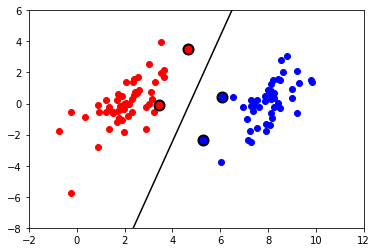

In [15]:
plt.figure()
plt.scatter(dataArr[labelArr == -1][:, 0],
            dataArr[labelArr == -1][:, 1], color="red")
plt.scatter(dataArr[labelArr == 1][:, 0],
            dataArr[labelArr == 1][:, 1], color="blue")
plt.plot(np.array([-2, 12]),
         ((-np.array([-2, 12]) * w[0] - b) / w[1]),
         color="black")
for i in range(len(alphas)):
    if alphas[i] > 0.0:
        if labelArr[i] == -1:
            plt.scatter(dataArr[i][0], dataArr[i][1],
                        color="red", edgecolors='black', s=100, linewidths=2)
        else:
            plt.scatter(dataArr[i][0], dataArr[i][1],
                        color="blue", edgecolors='black', s=100, linewidths=2)
plt.xlim(-2, 12)
plt.ylim(-8, 6)
plt.show()

In [16]:
# Full Platt SMO

In [17]:
dataArr, labelArr = loadDataSet('testSet.txt')

In [18]:
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 40)

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4


In [19]:
print(b)

-3.710327594390181


In [20]:
w = calcWs(alphas, dataArr, labelArr)
print(w)

[ 0.79217255 -0.25433037]


In [21]:
# support vectors
for i in range(len(alphas)):
    if alphas[i] > 0:
        print(dataArr[i], labelArr[i])

[3.634009 1.730537] -1.0
[4.658191 3.507396] -1.0
[ 3.457096 -0.082216] -1.0
[ 2.893743 -1.643468] -1.0
[ 5.286862 -2.358286] 1.0
[6.080573 0.418886] 1.0


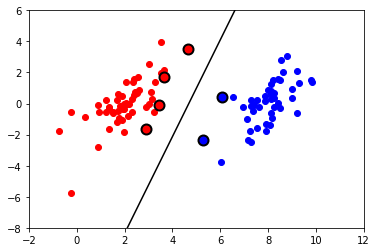

In [22]:
plt.figure()
plt.scatter(dataArr[labelArr == -1][:, 0],
            dataArr[labelArr == -1][:, 1], color="red")
plt.scatter(dataArr[labelArr == 1][:, 0],
            dataArr[labelArr == 1][:, 1], color="blue")
plt.plot(np.array([-2, 12]),
         ((-np.array([-2, 12]) * w[0] - b) / w[1]),
         color="black")
for i in range(len(alphas)):
    if alphas[i] > 0.0:
        if labelArr[i] == -1:
            plt.scatter(dataArr[i][0], dataArr[i][1],
                        color="red", edgecolors='black', s=100, linewidths=2)
        else:
            plt.scatter(dataArr[i][0], dataArr[i][1],
                        color="blue", edgecolors='black', s=100, linewidths=2)
plt.xlim(-2, 12)
plt.ylim(-8, 6)
plt.show()

In [23]:
print(np.dot(dataArr[0], w) + b)
print(labelArr[0])

-1.4069805750864268
-1.0


### Implement SVM (with kernel)

In [24]:
# Kernel transformation function
def kernelTrans(X, A, kTup):
    # kTup is a generic tuple that contains the information about the kernel
    m, n = X.shape
    K = np.zeros(m)
    if kTup[0] == 'lin':
        K = np.dot(X, A)
    elif kTup[0] == 'rbf':
        for j in range(m):
            deltaRow = X[j] - A
            K[j] = np.dot(deltaRow, deltaRow)
        # Element-wise division
        K = np.exp(K / (-1 * kTup[1] ** 2))
    else:
        raise NameError("Houston We Have a Problem -- "
                        "That Kernel is not recognized")
    return K


class optStruct:
    def __init__(self, dataMatIn, classLabels, C, toler, kTup):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = dataMatIn.shape[0]
        self.alphas = np.zeros(self.m)
        self.b = 0
        self.eCache = np.zeros((self.m, 2))
        self.K = np.zeros((self.m, self.m))
        for i in range(self.m):
            self.K[:, i] = kernelTrans(self.X, self.X[i], kTup)

In [25]:
# Changes to innerL() and calcEk() needed to user kernels
def calcEk(oS, k):
    fXk = np.dot(np.multiply(oS.alphas, oS.labelMat), oS.K[:, k]) + oS.b
    Ek = fXk - oS.labelMat[k]
    return Ek


# Full Platt SMO optimization routine
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i] * Ei < -oS.tol and oS.alphas[i] < oS.C)
            or (oS.labelMat[i] * Ei > oS.tol and oS.alphas[i] > 0)):
        # Second-choice heuristic
        j, Ej = selectJ(i, oS, Ei)
        alphaIold = oS.alphas[i]
        alphaJold = oS.alphas[j]
        if oS.labelMat[i] != oS.labelMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            # print("L == H")
            return 0
        eta = 2.0 * oS.K[i, j] - oS.K[i, i] - oS.K[j, j]
        if eta >= 0:
            # print("eta >= 0")
            return 0
        oS.alphas[j] -= oS.labelMat[j] * (Ei - Ej) / eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        # Updates Ecache
        updateEk(oS, j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            # print("j not moving enough")
            return 0
        oS.alphas[i] += (oS.labelMat[j] * oS.labelMat[i]
                         * (alphaJold - oS.alphas[j]))
        # Updates Ecache
        updateEk(oS, i)
        b1 = (oS.b - Ei
              - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[i, i]
              - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[i, j])
        b2 = (oS.b - Ej
              - oS.labelMat[i] * (oS.alphas[i] - alphaIold) * oS.K[i, j]
              - oS.labelMat[j] * (oS.alphas[j] - alphaJold) * oS.K[j, j])
        if 0 < oS.alphas[i] < oS.C:
            oS.b = b1
        elif 0 < oS.alphas[j] < oS.C:
            oS.b = b2
        else:
            oS.b = (b1 + b2) / 2
        return 1
    else:
        return 0

In [26]:
# Full Platt SMO outer loop
def smoP(dataMatIn, classLabels, C, toler, maxIter, kTup):
    oS = optStruct(dataMatIn, classLabels, C, toler, kTup)
    n_iter = 0
    entireSet = True
    alphaPairsChanged = 0
    while n_iter < maxIter and (alphaPairsChanged > 0 or entireSet):
        alphaPairsChanged = 0
        # Go over all values
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerL(i, oS)
                # print("fullSet, iter: %d i:%d, pairs changed %d"
                #       % (n_iter, i, alphaPairsChanged))
            n_iter += 1
        # Go over non-bound values
        else:
            nonBoundIs = np.nonzero((oS.alphas > 0) * (oS.alphas < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i, oS)
                # print("non-bound, iter: %d i:%d, pairs changed %d"
                #       % (n_iter, i, alphaPairsChanged))
            n_iter += 1
        if entireSet:
            entireSet = False
        elif alphaPairsChanged == 0:
            entireSet = True
        print("iteration number: %d" % n_iter)
    return oS.b, oS.alphas

### Experiment 1: Toy dataset

In [27]:
# Radial bias test function for classifying with a kernel
def testRbf(k1=1.3):
    dataArr, labelArr = loadDataSet('testSetRBF.txt')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1))
    # Create matrix of support vectors
    svInd = np.nonzero(alphas > 0)[0]
    sVs = dataArr[svInd]
    labelSV = labelArr[svInd]
    print("there are %d Support Vectors" % sVs.shape[0])

    plt.figure()
    plt.scatter(dataArr[labelArr == -1][:, 0],
                dataArr[labelArr == -1][:, 1], color="red")
    plt.scatter(dataArr[labelArr == 1][:, 0],
                dataArr[labelArr == 1][:, 1], color="blue")
    plt.scatter(sVs[labelSV == -1][:, 0], sVs[labelSV == -1][:, 1],
                color="red", edgecolors='black', s=100, linewidths=2)
    plt.scatter(sVs[labelSV == 1][:, 0], sVs[labelSV == 1][:, 1],
                color="blue", edgecolors='black', s=100, linewidths=2)
    plt.show()

    m, n = dataArr.shape
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataArr[i], ('rbf', k1))
        predict = np.dot(kernelEval, np.multiply(labelSV, alphas[svInd])) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print("the training error rate is: %f" % (errorCount / m))
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    m, n = dataArr.shape
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataArr[i], ('rbf', k1))
        predict = np.dot(kernelEval, np.multiply(labelSV, alphas[svInd])) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print("the test error rate is: %f" % (errorCount / m))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
there are 88 Support Vectors


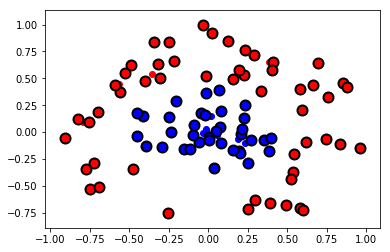

the training error rate is: 0.000000
the test error rate is: 0.080000


In [28]:
testRbf(k1=0.1)

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
there are 24 Support Vectors


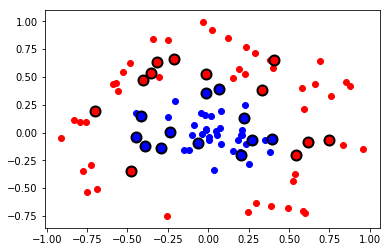

the training error rate is: 0.000000
the test error rate is: 0.070000


In [29]:
testRbf(k1=1.3)

### Experiment 2: Handwriting dataset

In [30]:
# Support vector machine handwriting recognition
def img2vector(filename):
    returnVect = np.zeros(1024)
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[32 * i + j] = int(lineStr[j])
    return returnVect


def loadImages(dirName):
    hwLabels = []
    trainingFileList = listdir(dirName)
    m = len(trainingFileList)
    trainingMat = np.zeros((m, 1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9:
            hwLabels.append(-1)
        else:
            hwLabels.append(1)
        trainingMat[i] = img2vector('%s/%s' % (dirName, fileNameStr))
    return np.array(trainingMat), np.array(hwLabels)


def testDigits(kTup=('rbf', 10)):
    dataArr, labelArr = loadImages('trainingDigits')
    b, alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    svInd = np.nonzero(alphas > 0)[0]
    sVs = dataArr[svInd]
    labelSV = labelArr[svInd]
    print("there are %d Support Vectors" % sVs.shape[0])
    m, n = dataArr.shape
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataArr[i], kTup)
        predict = np.dot(kernelEval, np.multiply(labelSV, alphas[svInd])) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print("the training error rate is: %f" % (errorCount / m))
    dataArr, labelArr = loadImages('testDigits')
    errorCount = 0
    m, n = dataArr.shape
    for i in range(m):
        kernelEval = kernelTrans(sVs, dataArr[i], kTup)
        predict = np.dot(kernelEval, np.multiply(labelSV, alphas[svInd])) + b
        if np.sign(predict) != np.sign(labelArr[i]):
            errorCount += 1
    print("the test error rate is: %f" % (errorCount / m))

In [31]:
testDigits(('rbf', 20))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
there are 51 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.016129


In [32]:
testDigits(('rbf', 0.1))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
there are 402 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.521505


In [33]:
testDigits(('rbf', 5))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
there are 402 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.032258


In [34]:
testDigits(('rbf', 10))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
there are 105 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.005376


In [35]:
testDigits(('rbf', 50))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
there are 34 Support Vectors
the training error rate is: 0.014925
the test error rate is: 0.010753


In [36]:
testDigits(('rbf', 100))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
there are 26 Support Vectors
the training error rate is: 0.044776
the test error rate is: 0.043011


In [37]:
testDigits(('lin',))

iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
there are 33 Support Vectors
the training error rate is: 0.007463
the test error rate is: 0.010753
